# Compare ML vs Gradient results 

In [1]:
import h5py
import pandas as pd
import os
from shapely.geometry import Polygon
from helper_functions.helper_functions import get_coords
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
from IPython.display import Image
from multiprocessing import Process, Queue, Pool

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import MaxNLocator, AutoLocator
import matplotlib.colors as mcol
import matplotlib.ticker as ticker
font = {'family' : 'serif',
         'size'   : 26,
         'serif':  'cmr10'
         }
plt.rc('font', **font)
plt.rc('axes', unicode_minus=False)
plt.rcParams.update({'font.size': 26})
pd.options.mode.chained_assignment = None

# new_rc_params = {
#     'text.usetex': False,
#     # "svg.fonttype": 'none'
# }
# mpl.rcParams.update(new_rc_params)

import pathlib
# temp = pathlib.PosixPath
# pathlib.PosixPath = pathlib.WindowsPath

In [2]:
# Load all files
def get_h5_file_paths(training_results, name, remove_debug=False):
    if remove_debug:
        filename =   [file[:-10]+".h5" for file in os.listdir(f"{training_results}") if file[-3:] != "pkl"]
        full_paths = [training_results +'/'+ file for file in os.listdir(f"{training_results}") if file[-3:] != "pkl"]
    else:
        filename =   [file for file in os.listdir(f"{training_results}") if file[-3:] != "pkl"]
        full_paths = [training_results +'/'+ file for file in os.listdir(f"{training_results}") if file[-3:] != "pkl"]
        # image_files_FINAL  = [(training_results +'/'+ file, file) for file in os.listdir(f"{training_results}") if file[-3:] != "pkl"]
    return {
        "name":name,
        "filename": filename,
        "full_path": full_paths
    } #(list(map(lambda f: training_results +'/'+f, image_files_FINAL)), image_files_FINAL)

# Gradient
GRADIENT_CZ    = get_h5_file_paths("/Home/siv32/eto033/fourier_files/gradient/2019-12-09/fourier", name="GRADIENT_CZ",    remove_debug=True)
GRADIENT_AS_02 = get_h5_file_paths("/Home/siv32/eto033/fourier_files/gradient/2020-02-05/fourier", name="GRADIENT_AS_02", remove_debug=True)
GRADIENT_AS_31 = get_h5_file_paths("/Home/siv32/eto033/fourier_files/gradient/2019-10-31/fourier", name="GRADIENT_AS_31", remove_debug=True)
# ML .h5
ML_CZ    = get_h5_file_paths("/Home/siv32/eto033/fourier_files/ML/2019-12-09/fourier", name="ML_CZ",    remove_debug=True)
ML_AS_02 = get_h5_file_paths("/Home/siv32/eto033/fourier_files/ML/2020-02-05/fourier", name="ML_AS_02", remove_debug=True)
ML_AS_31 = get_h5_file_paths("/Home/siv32/eto033/fourier_files/ML/2019-10-31/fourier", name="ML_AS_31", remove_debug=True)

print(f"{len(ML_AS_02['filename']) == len(GRADIENT_AS_02['filename'])} | {len(ML_AS_02['filename'])} == {len(GRADIENT_AS_02['filename'])}")
print(f"{len(ML_AS_31['filename']) == len(GRADIENT_AS_31['filename'])} | {len(ML_AS_31['filename'])} == {len(GRADIENT_AS_31['filename'])}")
print(f"{len(ML_CZ['filename']) == len(GRADIENT_CZ['filename'])} | {len(ML_CZ['filename'])} == {len(GRADIENT_CZ['filename'])}")
# GRADIENT_AS_02
all_files = [GRADIENT_AS_02, GRADIENT_AS_31, ML_CZ, ML_AS_02, ML_AS_31]
df = pd.DataFrame(GRADIENT_CZ)
for d in all_files:
    df = pd.concat((df, pd.DataFrame(d)))

df.reset_index(drop=True, inplace=True)
df

True | 70 == 70
True | 66 == 66
True | 81 == 81


,name,filename,full_path
0,GRADIENT_CZ,2019-12-09_15.27.44--NCz--T1437--GFP_Burst.h5,/Home/siv32/eto033/fourier_files/gradient/2019...
1,GRADIENT_CZ,2019-12-09_15.08.52--NCz--T1437--GFP_Burst.h5,/Home/siv32/eto033/fourier_files/gradient/2019...
2,GRADIENT_CZ,2019-12-09_15.19.11--NCz--T1437--GFP_Burst.h5,/Home/siv32/eto033/fourier_files/gradient/2019...
3,GRADIENT_CZ,2019-12-09_15.05.17--NCz--T1437--GFP_Burst.h5,/Home/siv32/eto033/fourier_files/gradient/2019...
4,GRADIENT_CZ,2019-12-09_14.47.11--NCz--T1334--GFP_Burst.h5,/Home/siv32/eto033/fourier_files/gradient/2019...
...,...,...,...
429,ML_AS_31,2019-10-31_12.47.30--NControlLongB--T1015-Burs...,/Home/siv32/eto033/fourier_files/ML/2019-10-31...
430,ML_AS_31,2019-10-31_12.49.52--NControlLongB--T1015-Burs...,/Home/siv32/eto033/fourier_files/ML/2019-10-31...
431,ML_AS_31,2019-10-31_12.51.58--NControlLongB--T1015-Burs...,/Home/siv32/eto033/fourier_files/ML/2019-10-31...
432,ML_AS_31,2019-10-31_12.54.48--NControlLongB--T1015-Burs...,/Home/siv32/eto033/fourier_files/ML/2019-10-31...


# Analyze files

In [3]:
# def analyze_h5_files(ML_PATH: str, GRADIENT_PATH: str, verbose=False):
#     # --------------- Load data  ---------------
#     fourier_pd_gradient = pd.read_hdf(
#         GRADIENT_PATH, key="fourier", mode="r"   
#     )
#     fourier_pd_ml = pd.read_hdf(
#         ML_PATH, key="fourier", mode="r"
#     )
#     fourier_pd_gradient_valid = fourier_pd_gradient[(fourier_pd_gradient['valid'] == True)]
#     fourier_pd_ml_valid = fourier_pd_ml[(fourier_pd_ml['valid'] == True)]
#     # assert fourier_pd_gradient_valid['frame'].max() == fourier_pd_ml_valid['frame'].max(), f"Unequal frames! Was {fourier_pd_gradient_valid['frame'].max()} != {fourier_pd_ml_valid['frame'].max()}"
#     min_frames = np.min((fourier_pd_gradient_valid['frame'].max(), fourier_pd_ml_valid['frame'].max()))
#     # assert (fourier_pd_gradient_valid['frame'].max() == fourier_pd_ml_valid['frame'].max()), f"{fourier_pd_gradient_valid['frame'].max()} != {fourier_pd_ml_valid['frame'].max()}"
#     # --------------- Valid granules ---------------
#     print("\n")
#     print(f"Current: {pathlib.Path(GRADIENT_PATH).stem}")
#     nr_valid = fourier_pd_gradient_valid[fourier_pd_gradient_valid['frame'] <= min_frames]['granule_id'].unique() 
#     print(f"Valid granules (gradient) | {nr_valid.size}")
#     nr_valid_ml = fourier_pd_ml_valid[fourier_pd_ml_valid['frame'] <= min_frames]['granule_id'].unique()
#     print(f"Valid granules (ML) | {nr_valid_ml.size} \n") 

#     granules_in_common_total = np.intersect1d(nr_valid, nr_valid_ml).size
#     gradient_exclusive_total = np.setdiff1d(nr_valid, nr_valid_ml).size
#     ml_exlusive_total = np.setdiff1d(nr_valid_ml, nr_valid).size

#     print("Union", granules_in_common_total)
#     print("Gradient Exclusive", gradient_exclusive_total)
#     print("ML Exclusive", ml_exlusive_total)
    
#     # --------------- Do comparison ---------------
#     IoU = []
#     area_gradient_list = []
#     area_ml_list = []
#     granule_ids = [] 
#     frames = []
#     gradient_mean_intensity, gradient_mean_radius, gradient_major_axis, gradient_minor_axis, gradient_eccentricity = [],[],[],[],[]
#     ml_mean_intensity, ml_mean_radius, ml_major_axis, ml_minor_axis, ml_eccentricity = [],[],[],[],[]
#     common, ml_ex, gradient_ex = [],[],[]

#     for frame_id in range(min_frames +1): # For all frames
#         granules_in_gradient_frame = fourier_pd_gradient_valid[fourier_pd_gradient_valid['frame'] == frame_id]
#         valid_granule_gradient_ids = granules_in_gradient_frame['granule_id'].unique() # All granules

#         granules_in_frame_ml = fourier_pd_ml_valid[fourier_pd_ml_valid['frame'] == frame_id]
#         # valid_granule_ids_ml = granules_in_frame_ml['granule_id'].unique() # All granules
#         # print(valid_granule_ids)
#         # print(valid_granule_ids_ml)
#         # assert np.array_equal(valid_granule_ids, valid_granule_ids_ml), "Should always be equal"
        
#         # TODO: Run this to ensure granule ids are the same for both files!!
#         # assert granule_f_gradient_terms['granule_id'].unique() == granule_f_terms_ml['granule_id'].unique(), f"Granule ID's are not the same! Was \n {granule_f_gradient_terms['granule_id'].unique()} \n {granule_f_terms_ml['granule_id'].unique()}"


#         granules_in_common = np.intersect1d(granules_in_gradient_frame['granule_id'].unique(), granules_in_frame_ml['granule_id'].unique())
#         gradient_exclusive = np.setdiff1d(granules_in_gradient_frame['granule_id'].unique(), granules_in_frame_ml['granule_id'].unique())
#         ml_exlusive = np.setdiff1d(granules_in_frame_ml['granule_id'].unique(), granules_in_gradient_frame['granule_id'].unique())
#         # print(f"Common {granules_in_common}")
#         # print(f"Gradient Exclusive {gradient_exclusive}")
#         # print(f"ML exclusive {ml_exlusive}")

#         # for granule_id in valid_granule_gradient_ids: # For all granules in frame       # TODO: Currently only considering granules that are in Gradient! This leaves unique granules that are in ML out!!
#         for granule_id in granules_in_common: # For all common granules in frame
            
#             granule_f_gradient_terms = granules_in_gradient_frame[granules_in_gradient_frame['granule_id'] == granule_id]
#             granule_f_terms_ml = granules_in_frame_ml[granules_in_frame_ml['granule_id'] == granule_id]

#             if granule_f_terms_ml.size == 0 :#or (granule_f_gradient_terms.iloc[0][['x','y']].tolist() != granule_f_terms_ml.iloc[0][['x','y']].tolist()):
#                 continue
#             elif granule_f_terms_ml['mean_radius'].iloc[0] == 0 or granule_f_gradient_terms['mean_radius'].iloc[0] == 0:
#                 if verbose:
#                     print("\nMean radius was 0!\n")
#                     # return # TODO: Test if this is ever triggered!!
#                 continue
#             # Compare x,y positions to verify comparisons happen with correct granules, irrespective of their id's
#             if (granule_f_gradient_terms.iloc[0][['x','y']].tolist() != granule_f_terms_ml.iloc[0][['x','y']].tolist()):
#                 if verbose:
#                     print(f"\n Granules not in same position! \n ML F:{granule_f_terms_ml['frame'].iloc[0]} Id: {granule_f_terms_ml['granule_id'].iloc[0]} Gradient F:{granule_f_gradient_terms['frame'].iloc[0]} Id: {granule_f_gradient_terms['granule_id'].iloc[0]}  \n{np.round(granule_f_gradient_terms.iloc[0][['x','y']].tolist(), 4)} != {np.round(granule_f_terms_ml.iloc[0][['x','y']].tolist(), 4)}")
#                 # return # TODO: Test if this is ever triggered!!
#                 continue

#             xs, ys = get_coords(granule_f_gradient_terms, get_relative=True)
#             xy = np.vstack((xs,ys)).T
#             area_gradient = Polygon(xy)

#             xs_ml, ys_ml = get_coords(granule_f_terms_ml, get_relative=True) 
#             xy = np.vstack((xs_ml,ys_ml)).T 
#             area_ml = Polygon(xy) 

#             if not area_gradient.is_valid or not area_ml.is_valid:
#                 if verbose:
#                     print(f"Invalid Gradient: {area_gradient.is_valid} ML: {area_ml.is_valid}") # TODO: Need to handle invalid geometries. Maybe add to csv, but note as 'invalid_geometry'
#                 continue 
#             intersection = area_gradient.intersection(area_ml).area / area_gradient.union(area_ml).area

#             IoU.append(intersection)
#             area_gradient_list.append(area_gradient.area)
#             area_ml_list.append(area_ml.area)
#             granule_ids.append(granule_f_gradient_terms.iloc[0]['granule_id'])
#             frames.append(granule_f_gradient_terms.iloc[0]['frame'])
#             gradient_mean_intensity.append(granule_f_gradient_terms.iloc[0]['mean_intensity'])
#             gradient_mean_radius.append(granule_f_gradient_terms.iloc[0]['mean_radius'])
#             gradient_major_axis.append(granule_f_gradient_terms.iloc[0]['major_axis'])
#             gradient_minor_axis.append(granule_f_gradient_terms.iloc[0]['minor_axis'])
#             gradient_eccentricity.append(granule_f_gradient_terms.iloc[0]['eccentricity'])      

#             ml_mean_intensity.append(granule_f_terms_ml.iloc[0]['mean_intensity'])
#             ml_mean_radius.append(granule_f_terms_ml.iloc[0]['mean_radius'])
#             ml_major_axis.append(granule_f_terms_ml.iloc[0]['major_axis'])
#             ml_minor_axis.append(granule_f_terms_ml.iloc[0]['minor_axis'])
#             ml_eccentricity.append(granule_f_terms_ml.iloc[0]['eccentricity'])  

#             common.append(True) 
#             ml_ex.append(False)  
#             gradient_ex.append(False) 
        
#         for granule_id in gradient_exclusive:
#             granule_f_gradient_terms = granules_in_gradient_frame[granules_in_gradient_frame['granule_id'] == granule_id]

#             if granule_f_gradient_terms.size == 0 :#or (granule_f_gradient_terms.iloc[0][['x','y']].tolist() != granule_f_terms_ml.iloc[0][['x','y']].tolist()):
#                 raise Exception(f"Granule does not exist? Frame: {frame_id} ID: {granule_id}")
            
#             xs, ys = get_coords(granule_f_gradient_terms, get_relative=True)
#             xy = np.vstack((xs,ys)).T
#             area_gradient = Polygon(xy)
#             assert granule_f_gradient_terms.iloc[0]['granule_id'] == granule_id
#             assert granule_f_gradient_terms.iloc[0]['frame'] == frame_id
            
#             IoU.append(None)
#             area_ml_list.append(None)
#             area_gradient_list.append(area_gradient.area)
#             granule_ids.append(granule_id)
#             frames.append(frame_id)
#             gradient_mean_intensity.append(granule_f_gradient_terms.iloc[0]['mean_intensity'])
#             gradient_mean_radius.append(granule_f_gradient_terms.iloc[0]['mean_radius'])
#             gradient_major_axis.append(granule_f_gradient_terms.iloc[0]['major_axis'])
#             gradient_minor_axis.append(granule_f_gradient_terms.iloc[0]['minor_axis'])
#             gradient_eccentricity.append(granule_f_gradient_terms.iloc[0]['eccentricity']) 

#             ml_mean_intensity.append(None)
#             ml_mean_radius.append(None)
#             ml_major_axis.append(None)
#             ml_minor_axis.append(None)
#             ml_eccentricity.append(None)  

#             common.append(False) 
#             ml_ex.append(False)  
#             gradient_ex.append(True) 
        
#         for granule_id in ml_exlusive:
#             granule_f_terms_ml = granules_in_frame_ml[granules_in_frame_ml['granule_id'] == granule_id]

#             if granule_f_terms_ml.size == 0 :#or (granule_f_gradient_terms.iloc[0][['x','y']].tolist() != granule_f_terms_ml.iloc[0][['x','y']].tolist()):
#                 raise Exception(f"Granule does not exist? Frame: {frame_id} ID: {granule_id}")
                
#             xs_ml, ys_ml = get_coords(granule_f_terms_ml, get_relative=True) 
#             xy = np.vstack((xs_ml,ys_ml)).T 
#             try:
#                 area_ml = Polygon(xy).area
#             except Exception as e:
#                 print("Ivalid geometry")
#                 print(e)
#                 area_ml = -1
            
#             IoU.append(None)
#             area_gradient_list.append(None)
#             area_ml_list.append(area_ml)
#             granule_ids.append(granule_id)
#             frames.append(frame_id)
#             gradient_mean_intensity.append(None)
#             gradient_mean_radius.append(None)
#             gradient_major_axis.append(None)
#             gradient_minor_axis.append(None)
#             gradient_eccentricity.append(None)       

#             ml_mean_intensity.append(granule_f_terms_ml.iloc[0]['mean_intensity'])
#             ml_mean_radius.append(granule_f_terms_ml.iloc[0]['mean_radius'])
#             ml_major_axis.append(granule_f_terms_ml.iloc[0]['major_axis'])
#             ml_minor_axis.append(granule_f_terms_ml.iloc[0]['minor_axis'])
#             ml_eccentricity.append(granule_f_terms_ml.iloc[0]['eccentricity']) 

#             common.append(False) 
#             ml_ex.append(True)  
#             gradient_ex.append(False) 

        
#     df = pd.DataFrame({
#         "granule_ids": granule_ids,
#         "frames": frames,
#         "area_gradient":area_gradient_list,
#         "area_ml":area_ml_list,
#         "IoU":IoU,
#         "gradient_mean_intensity": gradient_mean_intensity,
#         "gradient_mean_radius": gradient_mean_radius,
#         "gradient_major_axis": gradient_major_axis,
#         "gradient_minor_axis": gradient_minor_axis,
#         "gradient_eccentricity": gradient_eccentricity,

#         "ml_mean_intensity": ml_mean_intensity,
#         "ml_mean_radius": ml_mean_radius,
#         "ml_major_axis": ml_major_axis,
#         "ml_minor_axis": ml_minor_axis,
#         "ml_eccentricity": ml_eccentricity,
        
#         "granules_is_common": common,
#         "ml_exlusive": ml_ex,  
#         "gradient_exclusive": gradient_ex 
#     })
#     df['Gradient_valid'] = nr_valid.size
#     df['ML_valid'] = nr_valid_ml.size
#     df['Granules_in_common'] = granules_in_common_total
#     df['Gradient_exclusive'] = gradient_exclusive_total
#     df['ML_exlusive'] = ml_exlusive_total
#     df.to_csv(f"D:\Master\MasterProject\GE_result_analysis\comparison_results/{pathlib.Path(GRADIENT_PATH).stem}.cvs")

## Run only on files that have a Gradient & ML Pair 

In [3]:
REPLACE = False
files_to_analze = [] # (ML path, Gradient Path)

for experiment_pair in [('GRADIENT_CZ', 'ML_CZ'), ('GRADIENT_AS_02', 'ML_AS_02'), ('GRADIENT_AS_31', 'ML_AS_31')]: 
    gradient_ex_name, ml_ex_name = experiment_pair
    
    gradient_ex = df[df['name'] == gradient_ex_name]
    ml_ex = df[df['name'] == ml_ex_name]
    
    for index, row in gradient_ex.iterrows():
        # Check that GRADIENT has a matching ML file 
        ml_match = ml_ex[ml_ex['filename'] == row['filename']].iloc[0]
        # print(f"{ml_match} | {row['filename']}")
        # print("---")
        # break
        # print(ml_match)
        if ml_match.empty or (row['filename'] != ml_match['filename']): 
            print("Failed to find match!")
            print(row['filename'], "has no ML variant!")
            if not ml_match.empty:
                print(ml_match['filename'].iloc[0]) 
            print("------------")
            continue

        assert (pathlib.Path(ml_match['full_path']).stem == pathlib.Path(row['full_path']).stem), f"Files are not the same! Was: {pathlib.Path(ml_match['full_path']).stem} != { pathlib.Path(row['full_path']).stem}" 
        
        # ----- Skip training if already done -----
        potential_file = pathlib.Path(f"/Home/siv32/eto033/MasterProject/GE_result_analysis/comparison_results/{pathlib.Path(row['full_path']).stem}.cvs")
        if potential_file.exists():
            if not REPLACE:
                print(f"Results already exists for {pathlib.Path(row['full_path']).stem}. Skipping \n")
                continue
        
        files_to_analze.append((ml_match['full_path'], row['full_path']))
 
        # analyze_h5_files(ml_match['full_path'], row['full_path'], verbose=False)
    #     break
    # break

Results already exists for 2019-12-09_15.27.44--NCz--T1437--GFP_Burst--DEBUG. Skipping 

Results already exists for 2019-12-09_15.08.52--NCz--T1437--GFP_Burst--DEBUG. Skipping 

Results already exists for 2019-12-09_15.19.11--NCz--T1437--GFP_Burst--DEBUG. Skipping 

Results already exists for 2019-12-09_15.05.17--NCz--T1437--GFP_Burst--DEBUG. Skipping 

Results already exists for 2019-12-09_14.47.11--NCz--T1334--GFP_Burst--DEBUG. Skipping 

Results already exists for 2019-12-09_15.18.08--NCz--T1437--GFP_Burst--DEBUG. Skipping 

Results already exists for 2019-12-09_14.48.16--NCz--T1334--GFP_Burst--DEBUG. Skipping 

Results already exists for 2019-12-09_16.06.28--NCz--T1518--GFP_Burst--DEBUG. Skipping 

Results already exists for 2019-12-09_16.13.00--NCz--T1518--GFP_Burst--DEBUG. Skipping 

Results already exists for 2019-12-09_15.04.06--NCz--T1437--GFP_Burst--DEBUG. Skipping 

Results already exists for 2019-12-09_15.16.08--NCz--T1437--GFP_Burst--DEBUG. Skipping 

Results already exist

In [4]:
len(files_to_analze)

0

In [7]:
from compare_all_results_multiprocessing import analyze_h5_files, get_item_from_Queue


def multi_process(files_to_analze):
    # image_files_queue = Queue() 
    # for filenames in files_to_analze: # Populate Queue with filenames
    #     image_files_queue.put(filenames)

    # print(image_files_queue.qsize())
    # processes = [Process(target=get_item_from_Queue, args=(image_files_queue,)) for _ in range(6)]

    # for process in processes: 
    #     process.start() # Start

    # for process in processes:
    #     process.join()  # Stop

    
    pool = Pool(processes=70, maxtasksperchild=1)
    results = pool.map(analyze_h5_files, files_to_analze)
    print(results)

multi_process(files_to_analze)



Current: 2019-12-09_15.27.44--NCz--T1437--GFP_Burst--DEBUG
Valid granules (gradient) | 25
Valid granules (ML) | 24 

Union 24
Gradient Exclusive 1
ML Exclusive 0


Current: 2019-12-09_15.19.11--NCz--T1437--GFP_Burst--DEBUG
Valid granules (gradient) | 33
Valid granules (ML) | 32 

Union 31
Gradient Exclusive 2
ML Exclusive 1


Current: 2019-12-09_15.08.52--NCz--T1437--GFP_Burst--DEBUG
Valid granules (gradient) | 29
Valid granules (ML) | 27 

Union 27
Gradient Exclusive 2
ML Exclusive 0


Current: 2019-12-09_15.05.17--NCz--T1437--GFP_Burst--DEBUG
Valid granules (gradient) | 28
Valid granules (ML) | 26 

Union 25
Gradient Exclusive 3
ML Exclusive 1


Current: 2019-12-09_15.18.08--NCz--T1437--GFP_Burst--DEBUG


Current: 2019-12-09_14.47.11--NCz--T1334--GFP_Burst--DEBUG
Valid granules (gradient) | 42
Valid granules (gradient) | 19
Valid granules (ML) | 36 

UnionValid granules (ML) | 19 
 
36
UnionGradient Exclusive  186

Gradient ExclusiveML Exclusive  10

ML Exclusive 1


Current: 2019-

# Aggregate fittings

In [18]:
def get_agg(training_results, name):
    # filename =   [file[:-10]+".h5" for file in os.listdir(f"{training_results}") if file[-3:] != ".h5"]
    full_paths = [training_results +'/'+ file for file in os.listdir(f"{training_results}") if file[-3:] == ".h5"]
    # print(full_paths)

    agg_df = pd.read_hdf(full_paths[0], key="aggregate_data", mode="r")
    # print(agg_df.shape)
    for f in full_paths[1:]: # Read and concat all Aggregate_fittings.h5 files 
        loaded_df = pd.read_hdf(f, key="aggregate_data", mode="r")
        agg_df = pd.concat((agg_df, loaded_df))
        # print(agg_df.shape)

    return {
        "name":name,
        "data":agg_df
    } 

# Gradient
GRADIENT_CZ    = get_agg("/Home/siv32/eto033/fourier_files/gradient/2019-12-09",    name="GRADIENT_CZ")
GRADIENT_AS_02 = get_agg("/Home/siv32/eto033/fourier_files/gradient/2020-02-05", name="GRADIENT_AS_02")
GRADIENT_AS_31 = get_agg("/Home/siv32/eto033/fourier_files/gradient/2019-10-31", name="GRADIENT_AS_31")
# ML .h5

ML_CZ    = get_agg("/Home/siv32/eto033/fourier_files/ML/2019-12-09",    name="ML_CZ",  ) 
ML_AS_02 = get_agg("/Home/siv32/eto033/fourier_files/ML/2020-02-05", name="ML_AS_02")
ML_AS_31 = get_agg("/Home/siv32/eto033/fourier_files/ML/2019-10-31", name="ML_AS_31")

print(GRADIENT_CZ['data'].shape, ML_CZ['data'].shape)
print(GRADIENT_AS_02['data'].shape, ML_AS_02['data'].shape)
print(GRADIENT_AS_31['data'].shape, ML_AS_31['data'].shape)
print("\n")

aggregate_merge = None

for pair in [(GRADIENT_CZ, ML_CZ), (GRADIENT_AS_02, ML_AS_02), (GRADIENT_AS_31, ML_AS_31)]:
    aggregate_fittings_gradient, aggregate_fittings_ml = pair
    aggregate_fittings_gradient, aggregate_fittings_ml = aggregate_fittings_gradient['data'], aggregate_fittings_ml['data']

    aggregate_fittings_gradient = aggregate_fittings_gradient.query("sigma > 1e-10 and pass_rate > 0.6 and fitting_error < 0.6 and fitting_diff > 0.03")
    aggregate_fittings_ml = aggregate_fittings_ml.query("sigma > 1e-10 and pass_rate > 0.6 and fitting_error < 0.6 and fitting_diff > 0.03")

    print("ML granules       ", aggregate_fittings_ml.shape[0])
    print("Gradient granules ", aggregate_fittings_gradient.shape[0])
    
    aggregate = pd.merge(aggregate_fittings_gradient, aggregate_fittings_ml, how='inner', on=['x','y']) # 'granule_id',
    assert (aggregate['granule_id_x'] == aggregate['granule_id_y']).all(), f"All granules are NOT the same across files."
    if type(aggregate_merge) == "NoneType":
        aggregate_merge = aggregate
    else: 
        aggregate_merge = pd.concat([aggregate_merge, aggregate])

    print("Granules in common", aggregate.shape[0]) # Add 'x', 'y' to check if granules are the same    
    print("\n")
    # break

# print(aggregate_fittings_gradient['granule_id'].value_counts())
# print(aggregate_fittings_ml['granule_id'].value_counts())

(4400, 24) (4400, 24)
(7317, 24) (7317, 24)
(4462, 24) (4462, 24)


ML granules        1021
Gradient granules  1301
Granules in common 815


ML granules        1251
Gradient granules  1633
Granules in common 1063


ML granules        733
Gradient granules  1026
Granules in common 621




In [21]:
aggregate_merge.shape

(2499, 46)

In [22]:
GRADIENT_CZ['data'].columns.values

array(['granule_id', 'sigma', 'sigma_err', 'kappa_scale',
       'kappa_scale_err', 'mean_radius', 'figure_path', 'pass_rate',
       'fitting_error', 'durbin_watson', 'mean_intensity', 'image_path',
       'x', 'y', 'bbox_left', 'bbox_bottom', 'bbox_right', 'bbox_top',
       'q_2_mag', 'experiment', 'timestamp', 'fitting_diff', 'sigma_st',
       'sigma_errST'], dtype=object)

# Surface tension

In [23]:
aggregate_merge.rename(columns={'sigma_x':'sigma_gradient', 'sigma_err_x':'sigma_err_gradient','sigma_y':'sigma_ml', 'sigma_err_y':'sigma_err_ml', }, inplace=True)
# cols = ['granule_id', 'sigma_ml', 'sigma_err_ml', 'gradient_sigma_in_range_ml', 'ml_sigma_in_range_gradient', 'sigma_in_both_ranges']
combined_df = aggregate_merge#[['granule_id_x', 'sigma_ml', 'sigma_err_ml', 'sigma_gradient', 'sigma_err_gradient', 'gradient_sigma_in_range_ml', 'ml_sigma_in_range_gradient', 'sigma_in_both_ranges']]

lower =  combined_df['sigma_ml'] - combined_df['sigma_err_ml']
higher = combined_df['sigma_ml'] + combined_df['sigma_err_ml']
combined_df['gradient_sigma_in_range_ml'] = (lower <= combined_df['sigma_gradient']) & (combined_df['sigma_gradient'] <= higher) # Whether gradient sigma is within the ML's error interval

lower =  combined_df['sigma_gradient'] - combined_df['sigma_err_gradient']
higher = combined_df['sigma_gradient'] + combined_df['sigma_err_gradient']
combined_df['ml_sigma_in_range_gradient'] = (lower <= combined_df['sigma_ml']) & (combined_df['sigma_ml'] <= higher)

combined_df['sigma_in_both_ranges'] = (combined_df['ml_sigma_in_range_gradient'] & combined_df['gradient_sigma_in_range_ml'])    # Whether ML sigma is whithin the gradient error interval

import matplotlib
colors = matplotlib.colors.to_rgba_array(["g", "r"])
combined_df['both_in_range_color']     = [colors[0] if x else colors[1] for x in combined_df['sigma_in_both_ranges']] 
combined_df['both_in_range_color']     = [colors[0] if x else colors[1] for x in combined_df['sigma_in_both_ranges']] 
combined_df['gradient_in_range_color'] = [colors[0] if x else colors[1] for x in combined_df['gradient_sigma_in_range_ml']] 
combined_df['ML_in_range_color']       = [colors[0] if x else colors[1] for x in combined_df['ml_sigma_in_range_gradient']] 

# Calc std distance between ML to gradient relative to gradient
combined_df['std_sigma_distance'] = (combined_df['sigma_ml'] - combined_df['sigma_gradient']) / combined_df['sigma_err_gradient']
combined_df['std_sigma_distance_gradient_to_ml'] = (combined_df['sigma_ml'] - combined_df['sigma_gradient']) / combined_df['sigma_err_ml']

# combined_df.to_csv("Sigma_in_range.csv")
print(combined_df.shape)
combined_df[:2]

(2499, 54)


,granule_id_x,sigma_gradient,sigma_err_gradient,kappa_scale_x,kappa_scale_err_x,mean_radius_x,figure_path_x,pass_rate_x,fitting_error_x,durbin_watson_x,...,sigma_st_y,sigma_errST_y,gradient_sigma_in_range_ml,ml_sigma_in_range_gradient,sigma_in_both_ranges,both_in_range_color,gradient_in_range_color,ML_in_range_color,std_sigma_distance,std_sigma_distance_gradient_to_ml
0,0,8.677170e-08,2.913553e-08,0.857501,0.061746,0.628721,2019-12-09_15.27.44--NCz--T1437--GFP_Burst--G0...,0.691,0.080997,0.554252,...,5.830151e-07,1.707012e-07,False,False,False,"[1.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 1.0]",-2.556547,-28.286542
1,2,7.347779e-07,4.293685e-07,5.088202,0.716311,0.593302,2019-12-09_15.27.44--NCz--T1437--GFP_Burst--G0...,0.948,0.289913,0.610226,...,2.130326e-06,5.600004e-07,False,False,False,"[1.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 1.0]","[1.0, 0.0, 0.0, 1.0]",-1.060020,-3.315538


# Bending rigidity

In [24]:
lower =  combined_df['kappa_scale_y'] - combined_df['kappa_scale_err_y']
higher = combined_df['kappa_scale_y'] + combined_df['kappa_scale_err_y']
combined_df['gradient_kappa_in_range_ml'] = (lower <= combined_df['kappa_scale_x']) & (combined_df['kappa_scale_x'] <= higher)

lower =  combined_df['kappa_scale_x'] - combined_df['kappa_scale_err_x']
higher = combined_df['kappa_scale_x'] + combined_df['kappa_scale_err_x']
combined_df['ml_kappa_in_range_gradient'] = (lower <= combined_df['kappa_scale_y']) & (combined_df['kappa_scale_y'] <= higher)

combined_df['kappa_in_both_ranges'] = (combined_df['ml_kappa_in_range_gradient'] & combined_df['gradient_kappa_in_range_ml'])

In [25]:
# copy_df[['sigma_gradient', 'sigma_ml']]
# copy_df.columns

/tmp/ipykernel_563841/2663150553.py:2: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), layout='constrained',)


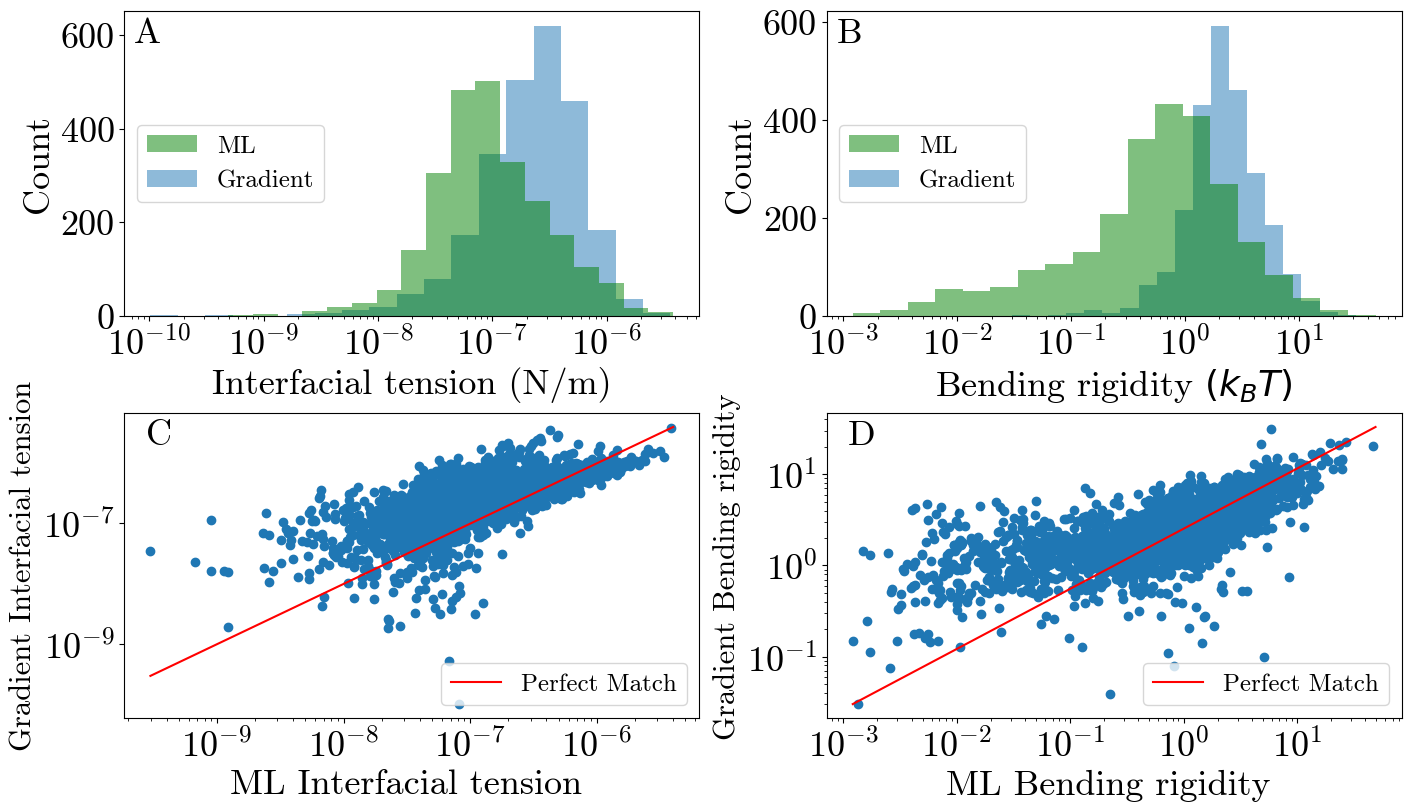

In [31]:
copy_df = combined_df.copy(deep=True)
fig, ((ax1,ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(14, 8), layout='constrained',)

# ---- ax1 ----
# hist, bins, y_handle = ax1.hist(copy_df['sigma_gradient'], label=f"ALL", bins=25, rasterized=True, alpha=0.5, )
start, stop = np.log10(min(copy_df['sigma_gradient'])), np.log10(max(copy_df['sigma_gradient']))
bins = 10 ** np.linspace(start, stop, 20)
hist, bins, y_handle = ax1.hist(copy_df['sigma_gradient'], label=f"ALL", bins=bins, rasterized=True, alpha=0.5, )

# hist, bins, x_handle = ax1.hist(copy_df['sigma_ml'],       label=f"ALL", bins=25, rasterized=True, alpha=0.5, color="green")
start, stop = np.log10(min(copy_df['sigma_ml'])), np.log10(max(copy_df['sigma_ml']))
bins = 10 ** np.linspace(start, stop, 20)
hist, bins, x_handle = ax1.hist(copy_df['sigma_ml'], label=f"ALL", bins=bins, rasterized=True, alpha=0.5, color="green")

ax1.legend((x_handle, y_handle, (x_handle, y_handle)), ('ML', 'Gradient'), fontsize=18, loc='center left')
ax1.set(xlabel="Interfacial tension (N/m)", ylabel="Count")
ax1.set_xscale('log')

# ---- ax2 ----
start, stop = np.log10(min(copy_df['kappa_scale_x'])), np.log10(max(copy_df['kappa_scale_x']))
bins = 10 ** np.linspace(start, stop, 20)
_, _, y_handle = ax2.hist(copy_df['kappa_scale_x'], label=f"ALL", bins=bins, rasterized=True, alpha=0.5, )

start, stop = np.log10(min(copy_df['kappa_scale_y'])), np.log10(max(copy_df['kappa_scale_y']))
bins = 10 ** np.linspace(start, stop, 20)
_, _, x_handle = ax2.hist(copy_df['kappa_scale_y'], label=f"ALL", bins=bins, rasterized=True, alpha=0.5, color="green")

ax2.legend((x_handle, y_handle, (x_handle, y_handle)), ('ML', 'Gradient'), fontsize=18, loc='center left')
ax2.set(xlabel="Bending rigidity $(k_B T)$", ylabel="Count")
ax2.set_xscale('log')

# ---- ax3 ----
ax3.scatter(copy_df['sigma_ml'], copy_df['sigma_gradient']) 
ax3.plot([np.min(copy_df['sigma_ml']), np.max(copy_df['sigma_ml'])*1.05], [np.min(copy_df['sigma_ml']), np.max(copy_df['sigma_gradient'])*1.05], label=f"Perfect Match", c='red', alpha=1)
# ax3.xaxis.set_major_formatter(mtick.FormatStrFormatter('%1.0e')) 
ax3.set_ylabel('Gradient Interfacial tension', fontsize = 22)
ax3.set_xlabel('ML Interfacial tension ', fontsize = 26)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.legend(fontsize=18, loc='lower right')

# ax3.scatter(copy_df[copy_df['sigma_in_both_ranges'] == True]['sigma_ml'], copy_df[copy_df['sigma_in_both_ranges'] == True]['sigma_gradient'], c='r') 
# ax3.scatter(copy_df[copy_df['gradient_sigma_in_range_ml'] == True]['sigma_ml'], copy_df[copy_df['gradient_sigma_in_range_ml'] == True]['sigma_gradient'], c='r') 
# ax3.scatter(copy_df[copy_df['ml_sigma_in_range_gradient'] == True]['sigma_ml'], copy_df[copy_df['ml_sigma_in_range_gradient'] == True]['sigma_gradient'], c='r', alpha=0.5) 

# ---- ax4 ----
ax4.scatter(copy_df['kappa_scale_y'], copy_df['kappa_scale_x'],) 
ax4.plot([np.min(copy_df['kappa_scale_y']), np.max(copy_df['kappa_scale_y'])*1.05], [np.min(copy_df['kappa_scale_x']), np.max(copy_df['kappa_scale_x'])*1.05],  label=f"Perfect Match", c='red', alpha=1)
ax4.set_ylabel('Gradient Bending rigidity', fontsize = 22)
ax4.set_xlabel('ML Bending rigidity ', fontsize = 26) # $(k_B T)$
ax4.set_xscale('log')
ax4.set_yscale('log')
ax4.legend(fontsize=18, loc='lower right')
# ax4.scatter(copy_df[copy_df['ml_kappa_in_range_gradient'] == True]['kappa_scale_y'], copy_df[copy_df['ml_kappa_in_range_gradient'] == True]['kappa_scale_x'], c='r', alpha=0.5) 


ax1.text(.04, .925, 'A', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes, color='Black')
ax2.text(.04, .925, 'B', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=ax2.transAxes, color='Black')
ax3.text(.06, .925, 'C', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=ax3.transAxes, color='Black')
ax4.text(.06, .925, 'D', fontsize=26, horizontalalignment='center', verticalalignment='center', transform=ax4.transAxes, color='Black')

# fig.show()
fig.savefig("../Overleaf_figures/Chapter5/5.2/granule_behaviour_model_comparison.svg")

In [47]:
both_true = copy_df[copy_df['sigma_in_both_ranges'] == True].shape[0]
both_false = copy_df[copy_df['sigma_in_both_ranges'] == False].shape[0]

gradient_ml_true = copy_df[copy_df['gradient_sigma_in_range_ml'] == True].shape[0]
gradient_ml_false = copy_df[copy_df['gradient_sigma_in_range_ml'] == False].shape[0]

ml_gradient_true = copy_df[copy_df['ml_sigma_in_range_gradient'] == True].shape[0]
ml_gradient_false = copy_df[copy_df['ml_sigma_in_range_gradient'] == False].shape[0]

print("-------- Sigma ---------")
print(f"Both in range        | True  {both_true}, False {both_false}, Ratio: {np.round(both_true/(both_true+both_false), 2)}")
print(f"Gradient in ml range | True  {gradient_ml_true}, False {gradient_ml_false}, Ratio: {np.round(gradient_ml_true/(gradient_ml_true+gradient_ml_false), 2)}") # Whether gradient sigma is within the ML's error interval
print(f"ML in gradient range | True {ml_gradient_true}, False {ml_gradient_false}, Ratio: {np.round(ml_gradient_true/(ml_gradient_true+ml_gradient_false), 2)}")
print("------------------------\n")


both_true = copy_df[copy_df['kappa_in_both_ranges'] == True].shape[0]
both_false = copy_df[copy_df['kappa_in_both_ranges'] == False].shape[0]

gradient_ml_true = copy_df[copy_df['gradient_kappa_in_range_ml'] == True].shape[0]
gradient_ml_false = copy_df[copy_df['gradient_kappa_in_range_ml'] == False].shape[0]

ml_gradient_true = copy_df[copy_df['ml_kappa_in_range_gradient'] == True].shape[0]
ml_gradient_false = copy_df[copy_df['ml_kappa_in_range_gradient'] == False].shape[0]

print("-------- Kappa ---------")
print(f"Both in range        | True  {both_true}, False {both_false}, Ratio: {np.round(both_true/(both_true+both_false), 2)}")
print(f"Gradient in ml range | True  {gradient_ml_true}, False {gradient_ml_false}, Ratio: {np.round(gradient_ml_true/(gradient_ml_true+gradient_ml_false), 2)}")
print(f"ML in gradient range | True {ml_gradient_true}, False {ml_gradient_false}, Ratio: {np.round(ml_gradient_true/(ml_gradient_true+ml_gradient_false), 2)}")
print("------------------------")


-------- Sigma ---------
Both in range        | True  612, False 1887, Ratio: 0.24
Gradient in ml range | True  682, False 1817, Ratio: 0.27
ML in gradient range | True 1062, False 1437, Ratio: 0.42
------------------------

-------- Kappa ---------
Both in range        | True  127, False 2372, Ratio: 0.05
Gradient in ml range | True  148, False 2351, Ratio: 0.06
ML in gradient range | True 135, False 2364, Ratio: 0.05
------------------------


In [ ]:
# fig, ((ax1,ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), layout='constrained',
#                                 )# sharex=True, sharey=True,)
# for t in [True, False]:
#     if t:
#         color = 'g'
#     else:
#         color = 'r'
    
#     copy_df = combined_df.copy(deep=True)
#     label = "Both in range" if t else "Both not in range"

#     ax1.scatter(copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance'], 
#                 copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance_gradient_to_ml'], 
#                 c=color, label=label) #, 'o', ls='-', ms=4)
#     ax1.legend(loc='lower right', prop={'size': 18})


#     label = "Gradient in range ML" if t else "Gradient not in range ML"
#     ax3.scatter(copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance'], 
#                 copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance_gradient_to_ml'],
#                 c=color, label=label, ) #, 'o', ls='-', ms=4)
#     ax3.legend(loc='lower right', prop={'size': 20})


#     label = "ML in range Gradient" if t else "ML not in range Gradient"
#     ax5.scatter(copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance'], 
#                 # list(1 for _ in range(len(copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['ml_sigma_in_range_gradient']))), 
#                 copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance_gradient_to_ml'], 
#                 c=color, label=label, ) #, 'o', ls='-', ms=4)
#     ax5.legend(loc='lower right',  prop={'size': 18})

# im0 = ax2.hist2d(copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance'], copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance_gradient_to_ml'], label=f"ALL", bins=25, cmap=plt.colormaps["inferno"], rasterized=True)
# cbar = fig.colorbar(im0[3], ax=ax2, ) #format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k")

# im0 = ax4.hist2d(copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance'], copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance_gradient_to_ml'], label=f"ALL", bins=25, cmap=plt.colormaps["inferno"], rasterized=True)
# cbar = fig.colorbar(im0[3], ax=ax4, ) #format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k")

# im0 = ax6.hist2d(copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance'], copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance_gradient_to_ml'], label=f"ALL", bins=25, cmap=plt.colormaps["inferno"], rasterized=True)
# cbar = fig.colorbar(im0[3], ax=ax6, ) #format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k")


# # fig.text(0.5, 0.04, 'common X', ha='center')
# fig.text(-0.03, 0.5, 'std ML from Gradient', va='center', rotation='vertical')
# fig.text(0.35, -0.03, 'std Gradient from ML', va='center')

# # plt.xlabel("std ML from gradient")
# # plt.ylabel("std Gradient from ML", loc='top')
# # plt.ylabel(" ")

# # fig.show()
# fig.savefig("../Overleaf_figures/Chapter5/5.2/in_range_plot.svg")

/tmp/ipykernel_563841/942389267.py:1: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  fig, ((ax1,ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), layout='constrained',
/tmp/ipykernel_563841/942389267.py:33: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im0[3], ax=ax2, ) #format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k")
/tmp/ipykernel_563841/942389267.py:36: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im0[3], ax=ax4, ) #format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k")
/tmp/ipykernel_563841/942389267.py:39: UserWarning: cmr10 font should ideally be used with mathtext, set axes.formatter.use_mathtext to True
  cbar = fig.colorbar(im0[3], ax=ax6, ) #format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k")


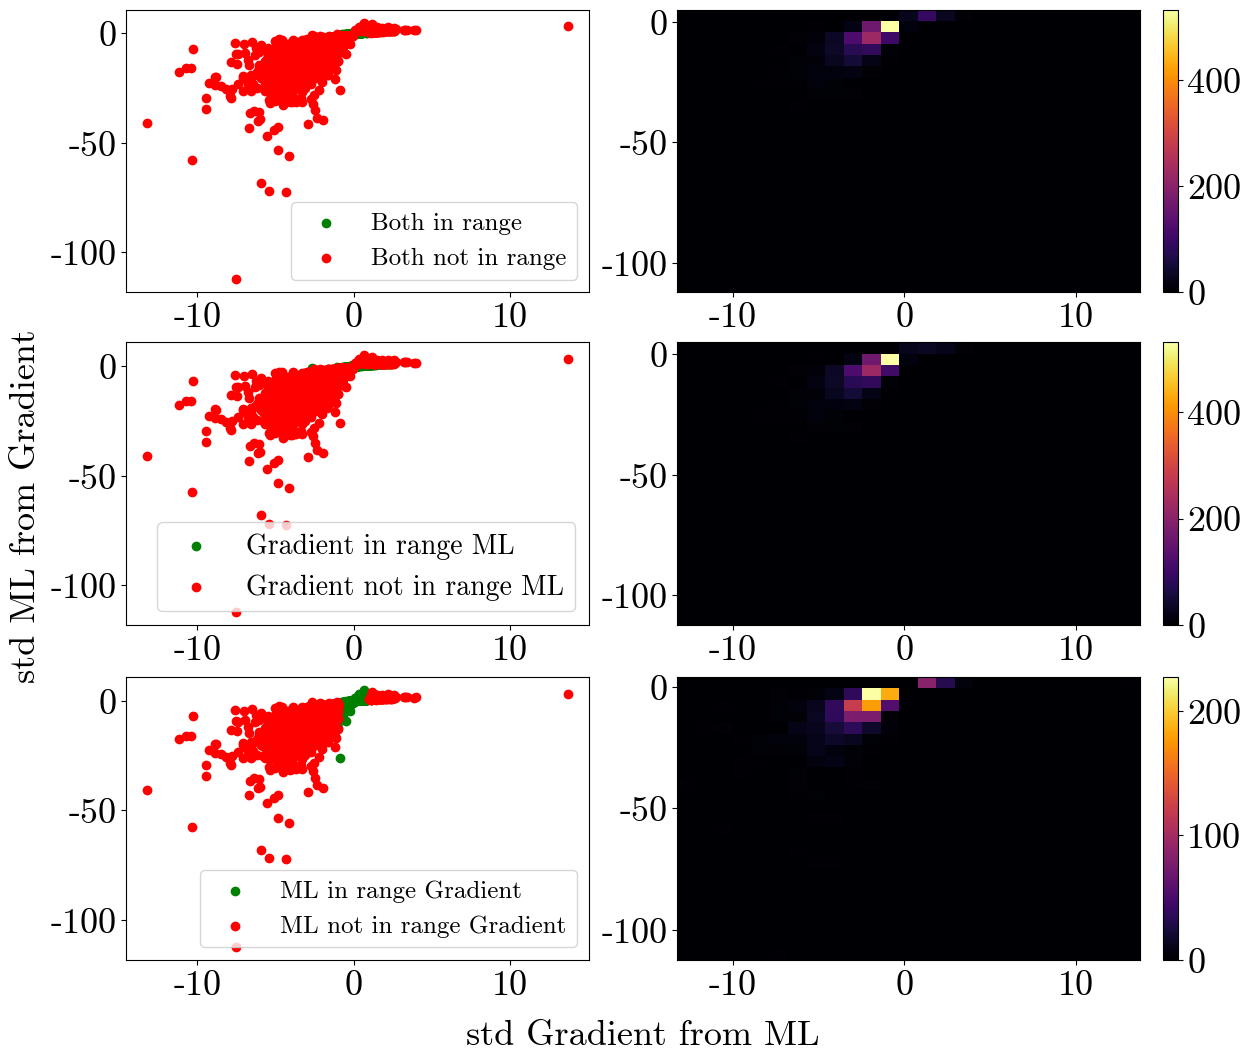

In [28]:
fig, ((ax1,ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(nrows=3, ncols=2, figsize=(12, 10), layout='constrained',
                                )# sharex=True, sharey=True,)
for t in [True, False]:
    if t:
        color = 'g'
    else:
        color = 'r'
    
    copy_df = combined_df.copy(deep=True)
    label = "Both in range" if t else "Both not in range"

    ax1.scatter(copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance'], 
                copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance_gradient_to_ml'], 
                c=color, label=label) #, 'o', ls='-', ms=4)
    ax1.legend(loc='lower right', prop={'size': 18})


    label = "Gradient in range ML" if t else "Gradient not in range ML"
    ax3.scatter(copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance'], 
                copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance_gradient_to_ml'],
                c=color, label=label, ) #, 'o', ls='-', ms=4)
    ax3.legend(loc='lower right', prop={'size': 20})


    label = "ML in range Gradient" if t else "ML not in range Gradient"
    ax5.scatter(copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance'], 
                # list(1 for _ in range(len(copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['ml_sigma_in_range_gradient']))), 
                copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance_gradient_to_ml'], 
                c=color, label=label, ) #, 'o', ls='-', ms=4)
    ax5.legend(loc='lower right',  prop={'size': 18})

im0 = ax2.hist2d(copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance'], copy_df[copy_df['sigma_in_both_ranges'] == t]['std_sigma_distance_gradient_to_ml'], label=f"ALL", bins=25, cmap=plt.colormaps["inferno"], rasterized=True)
cbar = fig.colorbar(im0[3], ax=ax2, ) #format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k")

im0 = ax4.hist2d(copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance'], copy_df[copy_df['gradient_sigma_in_range_ml'] == t]['std_sigma_distance_gradient_to_ml'], label=f"ALL", bins=25, cmap=plt.colormaps["inferno"], rasterized=True)
cbar = fig.colorbar(im0[3], ax=ax4, ) #format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k")

im0 = ax6.hist2d(copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance'], copy_df[copy_df['ml_sigma_in_range_gradient'] == t]['std_sigma_distance_gradient_to_ml'], label=f"ALL", bins=25, cmap=plt.colormaps["inferno"], rasterized=True)
cbar = fig.colorbar(im0[3], ax=ax6, ) #format=ticker.FuncFormatter(lambda x, pos: f"{int(x/1000)}k")


# fig.text(0.5, 0.04, 'common X', ha='center')
fig.text(-0.03, 0.5, 'std ML from Gradient', va='center', rotation='vertical')
fig.text(0.35, -0.03, 'std Gradient from ML', va='center')

# plt.xlabel("std ML from gradient")
# plt.ylabel("std Gradient from ML", loc='top')
# plt.ylabel(" ")

# fig.show()
fig.savefig("../Overleaf_figures/Chapter5/5.2/in_range_plot.svg")

ML method has clear bias towards lower superfacial tention and bending regidity. 

# Make heatmap version